In [1]:
!pip install matplotlib numpy pandas seaborn scikit-learn ipython
!pip install --upgrade kneed

import numpy as np
import math as mt
import pandas as pd
import random
import matplotlib.pyplot as plt
from queue import PriorityQueue
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.4 MB/s eta 0:00:00


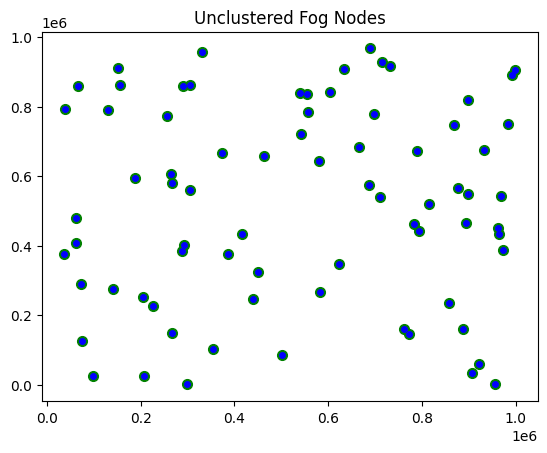

In [2]:
#Initiation
class SDN:
    def __init__(self, index, x, y, CPUcyc):
        self.id = index
        self.x = x
        self.y = y
        self.tasks_incoming = []
        self.tasks_priority_queue = PriorityQueue()
        self.fcfs_queue = PriorityQueue()
        self.sjf_queue = PriorityQueue()
        self.list_of_fns = []
        self.list_of_eus = []
        self.CPUcyc = CPUcyc

class FN:
    def __init__(self, index, x, y, freq, CPUcyc, failrate):
        self.id = index
        self.x = x
        self.y = y
        self.sdn_num = None
        self.freq = freq
        self.CPUcyc = CPUcyc
        self.failrate = failrate

class EU:
    def __init__(self, index, x, y):
        self.id = index
        self.x = x
        self.y = y
        self.sdn_num = None
        self.tasks = []

T = []
N = 5000
M = 75
eus = [] # list of all end users
fns = [] # list of all fog nodes
sdns = [] # list of all sdns
tasks = []
eus_pos = []
fns_pos = []
Co={}
SCo={}
Clu={}

# calculating failure rate of fog nodes using poisson distribution
def computeFailRate():
    _lambda = 25
    p = random.random()
    failrate = -(mt.log(1.0-p)/_lambda)
    return failrate
for i in range(M):
    x = random.random()*1000000
    y = random.random()*1000000
    freq = random.randint(1, 15)
    CPUcyc = random.randint(500, 1000)
    fns.append(FN(i, x, y, freq, CPUcyc, computeFailRate()))
    fns_pos.append([x,y])
for i in range(N):
    x = random.random()*1000000
    y = random.random()*1000000
    eus.append(EU(i, x, y))
    eus_pos.append([x,y])
plt.figure(facecolor='white')
ax=plt.axes()
ax.set_facecolor("white")
plt.rcParams["figure.figsize"] = [9.00, 9.00]
plt.rcParams["figure.autolayout"] = True

fn_np = np.array(fns_pos)
eu_np = np.array(eus_pos)
x, y = fn_np.T
plt.plot(x, y, 'go', ms=7)
# x, y = eu_np.T
plt.plot(x, y, 'bo', ms=4)

plt.title('Unclustered Fog Nodes')
plt.show()

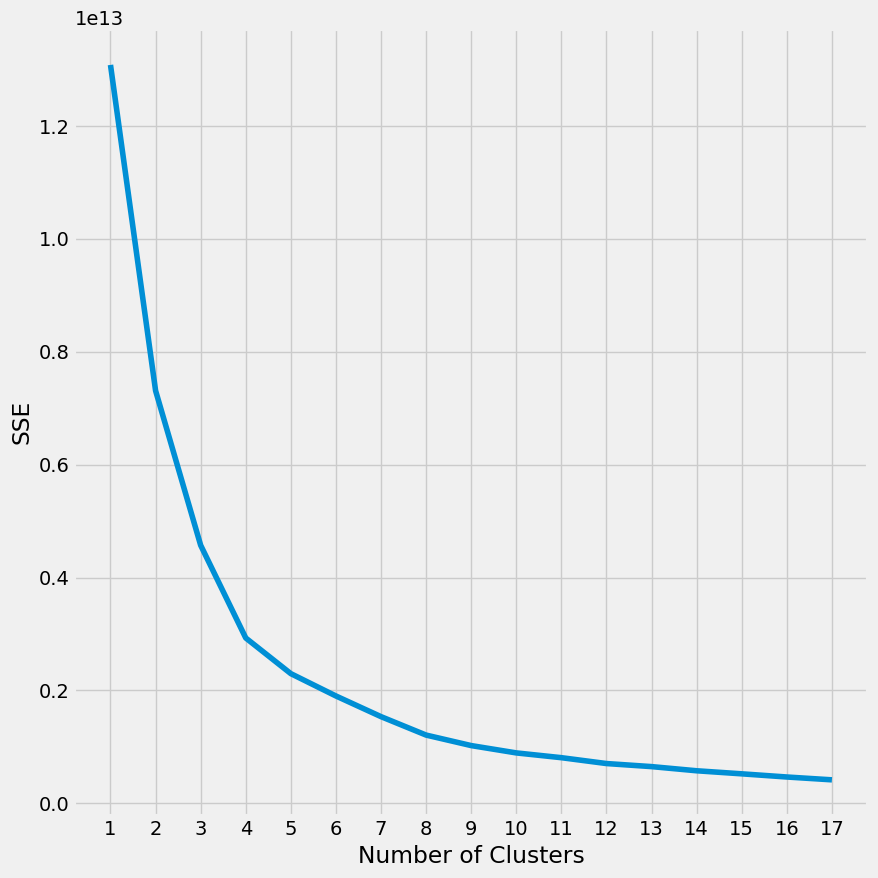

4


In [3]:
# Initially finding optimum number of clusters/SDNs - ELBOW METHOD
sse = []
max_clusters = int(M/4)
for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters=k, init= 'k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(fn_np)
    sse.append(kmeans.inertia_)
plt.style.use("fivethirtyeight")
plt.plot(range(1, max_clusters), sse)
plt.xticks(range(1, max_clusters))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
kl = KneeLocator(
    range(1, max_clusters), sse, curve="convex", direction="decreasing"
)
print(kl.elbow)

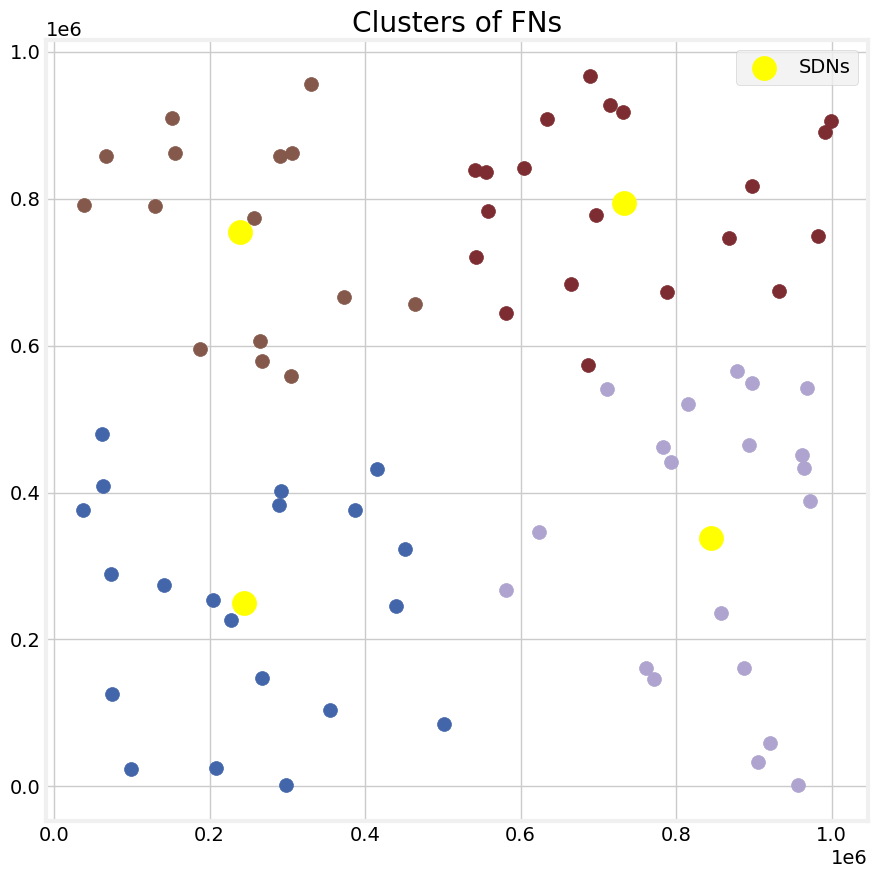

In [4]:
#Fog Nodes clustered (K Means)
kmeans = KMeans(
     init="random",
     n_clusters=kl.elbow,
     n_init=10,
     max_iter=300,
     random_state=42
  )
y_predict = kmeans.fit_predict(fn_np)
plt.figure(facecolor='white')
ax=plt.axes()
ax.set_facecolor("white")
for i in range(0,kl.elbow):
  color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
  plt.scatter(fn_np[y_predict == i, 0], fn_np[y_predict == i, 1], s = 100, c = color)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'SDNs')
plt.title('Clusters of FNs')

plt.legend()
plt.show()

for ind, centers in enumerate(kmeans.cluster_centers_):
    CPUcyc = random.randint(1000, 2000)
    sdns.append(SDN(ind, centers[0], centers[1], CPUcyc))

for fn_num, sdn_num in enumerate(y_predict):
  sdns[sdn_num].list_of_fns.append(fns[fn_num])
  fns[fn_num].sdn_num = sdn_num

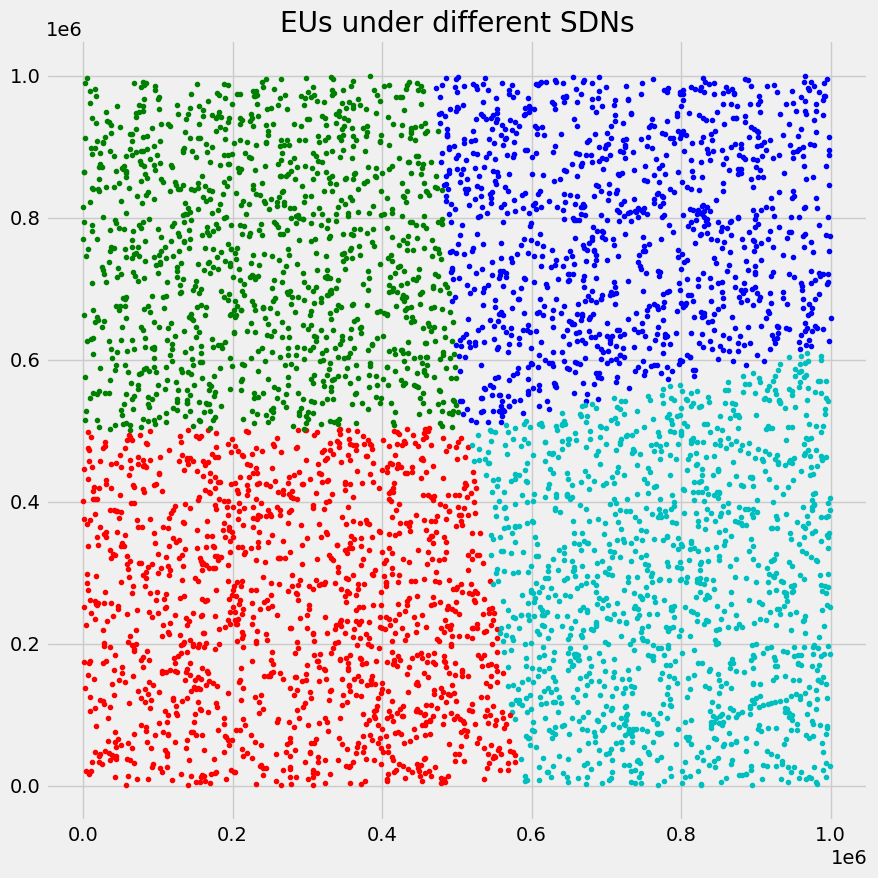

In [5]:
# EUs clustered according to governing SDNs (according to closest distance)
for i in range(N):
    Co[i]=[]
    for j in range(len(sdns)):
        d=mt.sqrt((eus[i].x-sdns[j].x)**2+(eus[i].y-sdns[j].y)**2)
        Co[i].append((j,d))
    Co[i]=sorted(Co[i], key=lambda x: x[1])

for i in range(N):
  num = Co[i][0][0]
  eus[i].sdn_num = num
  sdns[num].list_of_eus.append(eus[i])

x, y = eu_np.T
for i in range(N):
  if(eus[i].sdn_num==0):
    plt.plot(x[i],y[i],'bo',ms=3)
  elif(eus[i].sdn_num==1):
    plt.plot(x[i],y[i],'ro',ms=3)
  elif(eus[i].sdn_num==2):
    plt.plot(x[i],y[i],'go',ms=3)
  elif(eus[i].sdn_num==3):
    plt.plot(x[i],y[i],'co',ms=3)
  elif(eus[i].sdn_num==4):
    plt.plot(x[i],y[i],'mo',ms=3)

plt.title('EUs under different SDNs')
plt.show()

# for eu in eus:
#   print(str(eu.x) + " " + str(eu.y) +  " " + str(eu.sdn_num))

In [6]:
#Generate tasks
import sched, time
import pandas as pd
from time import mktime

class taskers:
    def __init__(self, id, gen_eu, gen_sdn, gen_time, deadline, size, freq, CPUcap, num):
        self.id = id
        self.gen_eu = gen_eu
        self.gen_sdn = gen_sdn
        self.gen_time = gen_time
        self.deadline = deadline
        self.size = size
        self.freq = freq
        self.CPUcap = CPUcap
        self.queue_pos = 0

    def __lt__(self, obj):
        """self < obj."""
        return self.id < obj.id



_lambda = 5
arrival_time = time.time()
cnt = 0

tasks.clear()

for sdn in sdns:
  sdn.tasks_incoming.clear()

for eu in eus:
  eu.tasks.clear()

def make_task(gen_eu, gen_sdn, count, arrival_time):
  random_time = arrival_time + random.uniform(250, 500)
  deadline = random_time
  size = random.randint(500, 2000) # in Bytes
  freq = 2.5 * pow(10, 2) # in MHz
  CPUcap = random.randint(500, 1000)
  return taskers(count, gen_eu, gen_sdn, arrival_time, deadline, size, freq, CPUcap, 0)

for sdn in sdns:
  lst = []
  for eu in sdn.list_of_eus:
    num = random.randint(0, 3) # number of tasks generated at each EU can vary from 0 to 3
    for i in range(num):
      p = random.random()
      inter_arrival_time = -(mt.log(1.0-p)/_lambda)
      # arrival_time = time.mktime(arrival_time.timetuple()) + arrival_time.microsecond/1e6 + inter_arrival_time
      arrival_time = arrival_time + inter_arrival_time
      task = make_task(eu.id, sdn.id, cnt, arrival_time)
      eu.tasks.append(task)
      sdn.tasks_incoming.append(task)
      tasks.append(task)
      cnt = cnt+1

for sdn in sdns:
  print(str(len(sdn.tasks_incoming))+" Tasks incoming at SDN "+str(sdn.id)+" :")
  sdn.tasks_priority_queue = PriorityQueue()
  for task in sdn.tasks_incoming:
    priority = 1/((task.deadline - task.gen_time) - (task.size/task.CPUcap))
    k = (priority, task)
    sdn.tasks_priority_queue.put(k)

for sdn in sdns:
  sdn.fcfs_queue = PriorityQueue()
  for task in sdn.tasks_incoming:
    priority = 1/task.gen_time
    k = (priority, task)
    sdn.fcfs_queue.put(k)

for sdn in sdns:
  sdn.sjf_queue = PriorityQueue()
  for task in sdn.tasks_incoming:
    priority = 1/(task.size/task.CPUcap)
    k = (priority, task)
    sdn.sjf_queue.put(k)

print("Count of tasks is " + str(cnt))

1632 Tasks incoming at SDN 0 :
2039 Tasks incoming at SDN 1 :
1740 Tasks incoming at SDN 2 :
1984 Tasks incoming at SDN 3 :
Count of tasks is 7395


In [7]:
def computeQueueingDelay(task, sdn):
  return task.freq * task.queue_pos / sdn.CPUcyc

In [8]:
def computeOffloadingDelay(task, fn):
  return task.size * task.freq / fn.CPUcyc

In [9]:
import math
class Channel:
  W = math.pow(10,7)
  No = 12.59 * math.pow(10,-15)
  h = 0.50
  p0 = 0.758
  gamma = 0.01
  d0 = 1000
  interPower = 50.119 * math.pow(10,-9)  # -109dBm
  shadowFactor = 0.3162
  commFailure = 0.002

  def get_pathloss(self, x1, y1, x2, y2):
    d = math.sqrt(math.pow(x2 - x1, 2)+ math.pow(y2 - y1,2))
    return self.p0 + (10 * self.gamma * math.log10(d/self.d0))

  def get_bw(self,power,x1,y1,x2,y2):
    pathLoss = self.get_pathloss(x1,y1,x2,y2)
    # d = math.sqrt(math.pow(x2 - x1, 2) + math.pow(y2 - y1, 2))
    #bw = math.log2(1+((self.h * power * math.pow(1/d,pathLoss))/(self.No)))
    bw = math.log2(1+((self.shadowFactor * power * pathLoss)/(self.interPower + (self.W* self.No))))
    return bw

def computeTransmissionDelay(task, fn):
  gen_eu = eus[task.gen_eu]
  ch= Channel()
  return ch.get_bw(0.5, gen_eu.x, gen_eu.y, fn.x, fn.y)

In [10]:
sdn = sdns[0]
num_tasks = 100 # the number of tasks we are taking from the priority queue at any instance and assigning it

connections = {}

for i in range(num_tasks):
    task = sdn.tasks_priority_queue.get()[1]
    allowed_delay = task.deadline-task.gen_time
    task.queue_pos = i+1
    connections[i] = {}
    connections[i]['task_id'] = task.id
    connections[i]['fns'] = []
    qd = computeQueueingDelay(task, sdn)
    for fn in sdn.list_of_fns:
        if(fn.failrate > 0.05):
          pass
        od = computeOffloadingDelay(task, fn)
        td = computeTransmissionDelay(task, fn)
        total_delay = qd + od + td
        # print("qd " + str(qd))
        # print("od " + str(od))
        # print("td " + str(td))
        # print("total " + str(total_delay))
        if(total_delay <= allowed_delay):
          connections[i]['fns'].append(fn.id)

for item in connections.items():
  print(item)

(0, {'task_id': 577, 'fns': [3, 5, 12, 14, 21, 23, 29, 32, 33, 35, 39, 43, 46, 48, 52, 56, 62, 64, 67, 70]})
(1, {'task_id': 926, 'fns': [3, 5, 12, 14, 21, 23, 29, 32, 33, 35, 39, 43, 46, 48, 52, 56, 62, 64, 67, 70]})
(2, {'task_id': 1256, 'fns': [3, 5, 12, 14, 21, 23, 29, 32, 33, 35, 39, 43, 46, 48, 52, 56, 62, 64, 67, 70]})
(3, {'task_id': 983, 'fns': [5, 14, 29, 39, 43, 62, 64, 67, 70]})
(4, {'task_id': 1602, 'fns': [5, 14, 39, 43, 62]})
(5, {'task_id': 743, 'fns': [5, 14, 29, 39, 43, 62, 64, 67]})
(6, {'task_id': 254, 'fns': [5, 12, 14, 29, 35, 39, 43, 46, 48, 52, 56, 62, 64, 67, 70]})
(7, {'task_id': 664, 'fns': [5, 12, 14, 29, 39, 43, 46, 48, 52, 62, 64, 67, 70]})
(8, {'task_id': 846, 'fns': [5, 14, 29, 39, 43, 62, 64, 67]})
(9, {'task_id': 1546, 'fns': [62]})
(10, {'task_id': 639, 'fns': [5, 14, 29, 39, 43, 62, 64, 67]})
(11, {'task_id': 924, 'fns': [62]})
(12, {'task_id': 297, 'fns': [62]})
(13, {'task_id': 970, 'fns': [3, 5, 12, 14, 21, 29, 32, 33, 35, 39, 43, 46, 48, 52, 56, 

In [11]:
from matplotlib.markers import JoinStyle
from pprint import pprint
from matplotlib import pyplot as plt

import numpy as np


class GSA:
    def __init__(self, pop_size=1, tasks=1, max_iter=100):
        self.cost_func = None

        self.alpha = 0.1
        self.G = 0.9
        self.max_iter = max_iter
        self.pop_size = pop_size
        self.tasks = tasks
        self.best_so_far = None

        self.X = np.random.rand(pop_size, tasks)
        self.V = np.random.rand(pop_size, tasks)
        self.f = np.full((pop_size, tasks), None)  # None  # Will become a list inside cal_f
        self.a = np.full((pop_size, tasks), None)
        self.q = np.full((pop_size, 1), None)
        self.M = np.full((pop_size, 1), None)
        self.cost_matrix = np.full((pop_size, 1), None)
        self.max_delay = None
        self.avg_delay = None

    # generates initial population
    def generate_initial_pop(self):
        for i in range(self.pop_size):
            for j in range(0, self.tasks):
                self.X[i][j] = random.uniform(0, len(connections[j]['fns'])-1)

    # Evaluate a single x (x_i)
    def evaluate(self, args):
        return self.cost_func(args)

    # Generate the cost of all particles
    def gen_cost_matrix(self):
        for i, x in enumerate(self.X):
          self.cost_matrix[i] = self.evaluate(x)

    def cal_q(self):
        best = np.min(self.cost_matrix)
        worst = np.max(self.cost_matrix)

        self.q = (self.cost_matrix - worst) / best - worst

    def cal_m(self):
        self.M = self.q / np.sum(self.q)

    def cal_f(self):
        costs = self.cost_matrix.copy()
        costs.sort(axis=0)
        costs = costs

        for i in range(self.pop_size):
            f = None
            for cost in costs:
                tmp = np.where(self.cost_matrix == cost)[0]
                j = tmp[0]

                dividend = float(self.M[i] * self.M[j])
                divisor = np.sqrt(np.sum((self.X[i] - self.X[j]) ** 2)) + np.finfo('float').eps
                if f is None:
                    f = self.G * (dividend / divisor) * (self.X[j] - self.X[i])
                else:
                    f = f + self.G * (dividend / divisor) * (self.X[j] - self.X[i])

            self.f[i] = np.random.uniform(0, 1) * f

    def cal_a(self):
        for i in range(self.pop_size):
            self.a[i] = self.f[i] / self.M[i]

    def cal_v(self):
        self.V = (np.random.uniform(0, 1) * self.V) + self.a

    def move(self):
        self.X = self.X + self.V

    def update_g(self, iteration):
        self.G = self.G * np.e ** (- self.alpha * (iteration / self.max_iter))

    def show_results(self):
        self.avg_delay = self.evaluate(self.best_so_far)/num_tasks
        # self.max_delay = find_max_cost(self.best_so_far)
        # print('Best seen so far is located at: ', self.best_so_far, 'Cost:', self.evaluate(self.best_so_far))
        print('Average delay:', self.avg_delay)
        # print('Max delay: ', self.max_delay)


    def update_best_so_far(self):
        best = np.min(self.cost_matrix)
        tmp = np.where(self.cost_matrix == best)[0]
        index = tmp[0]
        # if self.best_so_far is not None:
        #     print("best " + str(self.evaluate(self.best_so_far)))

        if self.best_so_far is None or self.evaluate(self.best_so_far) > best:
            self.best_so_far = self.X[index]

    def start(self):
        _iter = 0
        self.generate_initial_pop()
        avg = []
        bsf = []
        while _iter < self.max_iter:
            self.gen_cost_matrix()
            self.cal_q()
            self.cal_m()
            self.update_g(_iter)
            self.cal_f()
            self.cal_a()
            self.cal_v()
            self.move()
            self.update_best_so_far()

            avg.append(sum(self.cost_matrix) / len(self.cost_matrix))
            bsf.append(self.evaluate(self.best_so_far))

            _iter += 1
        else:
            self.show_results()
            print("The optimal assignment is as follows: ")
            optim = self.best_so_far
            # for task_idx, fn_idx in enumerate(optim):
            #     if len(connections[task_idx]['fns']) != 0:
            #         print("Task " + str(connections[task_idx]['task_id']) + " is assigned to fog node " + str(connections[task_idx]['fns'][int(fn_idx)]))
            #     else:
            #         print("Task " + str(connections[task_idx]['task_id']) + " is not assigned")
            plt.figure()
            # avg_plt = plt.subplot(1, 2, 1)
            # avg_plt.plot(avg, color='gold')
            # bsf_plt = plt.subplot(1, 2, 2)
            # bsf_plt.plot(bsf, color='darkviolet')
            plt.show()


# Minimize function
def fitness_func(args):
    pop = args
    cost = 0
    for task_idx, fn_idx in enumerate(pop):
        if(len(connections[task_idx]['fns'])) != 0:
            task = tasks[connections[task_idx]['task_id']]
            fn_idx = min(int(fn_idx), len(connections[task_idx]['fns'])-1 )
            fn = fns[connections[task_idx]['fns'][int(fn_idx)]];
            delay = computeOffloadingDelay(task, fn) + computeQueueingDelay(task, sdns[0]) + computeTransmissionDelay(task, fn)
            cost += 0.5*delay + 0.5*fn.failrate
    return cost

def find_max_cost(args):
    pop = args
    mx = 0
    for task_idx, fn_idx in enumerate(pop):
        if(len(connections[task_idx]['fns'])) != 0:
            task = tasks[connections[task_idx]['task_id']]
            fn_idx = min(int(fn_idx), len(connections[task_idx]['fns'])-1 )
            fn = fns[connections[task_idx]['fns'][int(fn_idx)]];
            delay = computeOffloadingDelay(task, fn) + computeQueueingDelay(task, sdns[0]) + computeTransmissionDelay(task, fn)
            mx = max(mx, delay)
    return mx

gsa = GSA(pop_size=20, tasks=num_tasks, max_iter=300)
gsa.cost_func = fitness_func
gsa.start()

<ipython-input-11-f3364fb21367>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dividend = float(self.M[i] * self.M[j])


Average delay: 177.00557095011547
The optimal assignment is as follows: 


<Figure size 900x900 with 0 Axes>

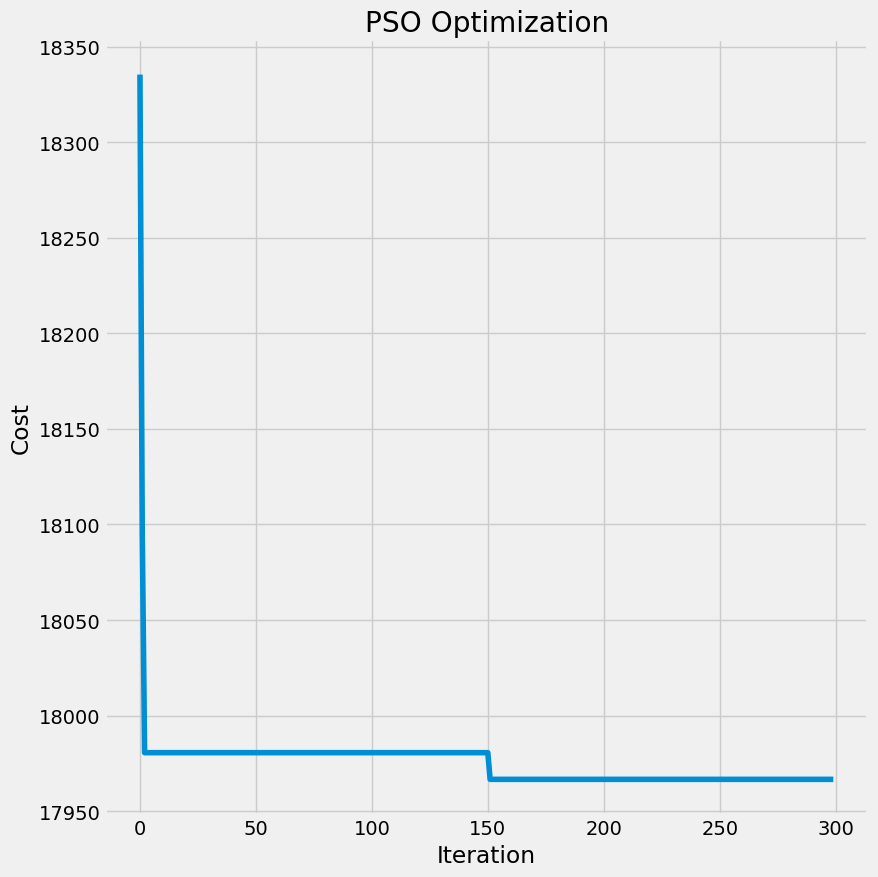

Optimal assignment: [ 1.28570522  0.13537467 -0.22315934  1.27740936  1.32264321  0.81495058
  0.45077659  0.7179367   1.57139364  0.99440102  0.41574039  0.96093174
  0.93568995  0.43772485  1.39409287  1.29238266  1.16961838 -0.09478759
  0.62977206  1.83095601  0.18496936  0.93090201  0.17656111  1.45320864
 -0.18761993 -0.03118887  1.5796757   0.31825657  1.40082907  1.27612712
  0.34529633  0.66884837 -0.15792551  1.38268287  0.33552367  0.2086493
  0.56953532  1.03397911  0.9140263   1.04813953  0.7863116   0.56593667
 -0.01494452  0.42687268  1.07293753  1.20146619  0.70719896  1.44545066
 -0.01584419  0.51066052  0.98183311  0.30097007  0.63332168  0.87665121
  0.49711774  0.57197639  1.63505046  1.09107219  0.5810685   0.12047062
  0.59554424  0.58373146  0.67514001  0.55854184  0.5458146   0.64583408
  1.35180164  0.60227033  1.60453563  1.9337376   1.50561942  1.42604502
  0.43610911  0.70089229  0.87423683  1.37410925  1.44185036  0.38387051
  0.5908723   0.68341759  1.8676

In [12]:
import random
import numpy as np
from matplotlib import pyplot as plt

class PSO:
    def __init__(self, pop_size=1, tasks=1, max_iter=100):
        self.cost_func = None

        self.w = 0.5  # Inertia weight
        self.c1 = 1.5  # Cognitive weight
        self.c2 = 1.5  # Social weight
        self.max_iter = max_iter
        self.pop_size = pop_size
        self.tasks = tasks
        self.best_positions = np.random.rand(pop_size, tasks)
        self.velocities = np.random.rand(pop_size, tasks)
        self.personal_best = self.best_positions.copy()
        self.global_best = self.best_positions[random.randint(0, pop_size - 1)].copy()
        self.global_best_cost = float('inf')
        self.costs = []

    def evaluate(self, args):
        return self.cost_func(args)

    def update_velocity(self):
        for i in range(self.pop_size):
            r1, r2 = random.random(), random.random()
            cognitive = self.c1 * r1 * (self.personal_best[i] - self.best_positions[i])
            social = self.c2 * r2 * (self.global_best - self.best_positions[i])
            self.velocities[i] = self.w * self.velocities[i] + cognitive + social

    def update_position(self):
        self.best_positions += self.velocities

    def update_personal_best(self):
        for i in range(self.pop_size):
            cost = self.evaluate(self.best_positions[i])
            if cost < self.evaluate(self.personal_best[i]):
                self.personal_best[i] = self.best_positions[i]
                if cost < self.global_best_cost:
                    self.global_best = self.best_positions[i].copy()
                    self.global_best_cost = cost

    def start(self):
        _iter = 0
        while _iter < self.max_iter:
            self.update_velocity()
            self.update_position()
            self.update_personal_best()
            self.costs.append(self.global_best_cost)  # Append gbest cost, not self.evaluate(self.global_best)
            _iter += 1

        plt.plot(self.costs)
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.title('PSO Optimization')
        plt.show()
        print("Optimal assignment:", self.global_best)
        print("Minimum cost:", self.global_best_cost)

# Define your fitness function and other necessary functions here

pso = PSO(pop_size=20, tasks=num_tasks, max_iter=300)
pso.cost_func = fitness_func
pso.start()

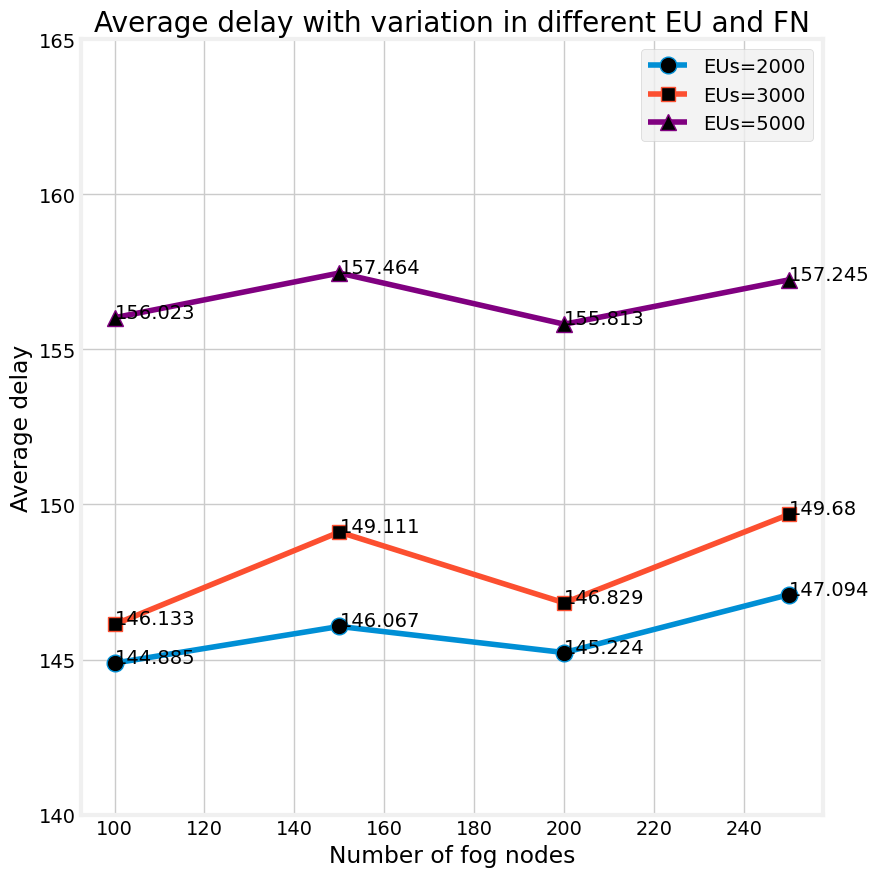

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(facecolor='white')
ax=plt.axes()
ax.set_facecolor("white")
fns = np.array([100, 150, 200, 250])
eu2000 = np.array([144.88521818669324, 146.06725206162955, 145.22425324823445, 147.0944319462382])
eu3000 = np.array([146.1333805900228, 149.11131576904023, 146.82895900570546, 149.68006959722175])
eu5000 = np.array([156.02282726597792, 157.46426469279453, 155.81313531409026, 157.2445276467267])
# first plot with X and Y data
plt.plot(fns, eu2000, label="EUs=2000", marker='o', markerfacecolor='black', markersize=12)
plt.plot(fns, eu3000, label="EUs=3000", marker='s', markerfacecolor='black', markersize=10)
plt.plot(fns, eu5000, label="EUs=5000", marker='^', markerfacecolor='black', markersize=12, color='purple')

plt.xlabel("Number of fog nodes")
plt.ylabel("Average delay")
plt.title('Average delay with variation in different EU and FN')
plt.legend()

for x, y in zip(fns, eu2000):
    plt.text(x, y, f"{round(y, 3)}", fontsize=14)

for x, y in zip(fns, eu3000):
    plt.text(x, y, f"{round(y, 3)}", fontsize=14)

for x, y in zip(fns, eu5000):
    plt.text(x, y, f"{round(y, 3)}", fontsize=14)

plt.ylim(140, 165)
plt.show()

In [ ]:
fcfs_connections = {}

for i in range(num_tasks):
    task = sdn.fcfs_queue.get()[1]
    allowed_delay = task.deadline-task.gen_time
    task.queue_pos = i+1
    fcfs_connections[i] = {}
    fcfs_connections[i]['task_id'] = task.id
    fcfs_connections[i]['fns'] = []
    qd = computeQueueingDelay(task, sdn)
    for fn in sdn.list_of_fns:
        if(fn.failrate > 0.05):
          pass
        od = computeOffloadingDelay(task, fn)
        td = computeTransmissionDelay(task, fn)
        total_delay = qd + od + td
        if(total_delay <= allowed_delay):
          fcfs_connections[i]['fns'].append(fn.id)


# for item in fcfs_connections.items():
#   print(item)

In [ ]:
sjf_connections = {}

for i in range(num_tasks):
    task = sdn.sjf_queue.get()[1]
    allowed_delay = task.deadline-task.gen_time
    task.queue_pos = i+1
    sjf_connections[i] = {}
    sjf_connections[i]['task_id'] = task.id
    sjf_connections[i]['fns'] = []
    qd = computeQueueingDelay(task, sdn)
    for fn in sdn.list_of_fns:
        if(fn.failrate > 0.05):
          pass
        od = computeOffloadingDelay(task, fn)
        td = computeTransmissionDelay(task, fn)
        total_delay = qd + od + td
        # print("qd " + str(qd))
        # print("od " + str(od))
        # print("td " + str(td))
        # print("total " + str(total_delay))
        if(total_delay <= allowed_delay):
          sjf_connections[i]['fns'].append(fn.id)


# for item in sjf_connections.items():
#     print(item)

In [ ]:
labels = [100, 200, 300]
unassigned = [16, 30, 65]
sjf_unassigned = [89, 170, 251]
fcfs_unassigned = [42, 85, 137]


# cnt = 0
# fcfs_cnt = 0
# sjf_cnt = 0
# i = 0

# for j in range(len(connections)):
#     if len(connections[j]['fns']) == 0:
#         cnt = cnt + 1
#     if len(fcfs_connections[j]['fns']) == 0:
#         fcfs_cnt = fcfs_cnt + 1
#     if len(sjf_connections[j]['fns']) == 0:
#         sjf_cnt = sjf_cnt + 1

#     if labels[i]== j+1 :
#         unassigned.append(cnt)
#         fcfs_unassigned.append(fcfs_cnt)
#         sjf_unassigned.append(sjf_cnt)
#         i = i + 1

# print(unassigned)
# print(fcfs_unassigned)
# print(sjf_unassigned)

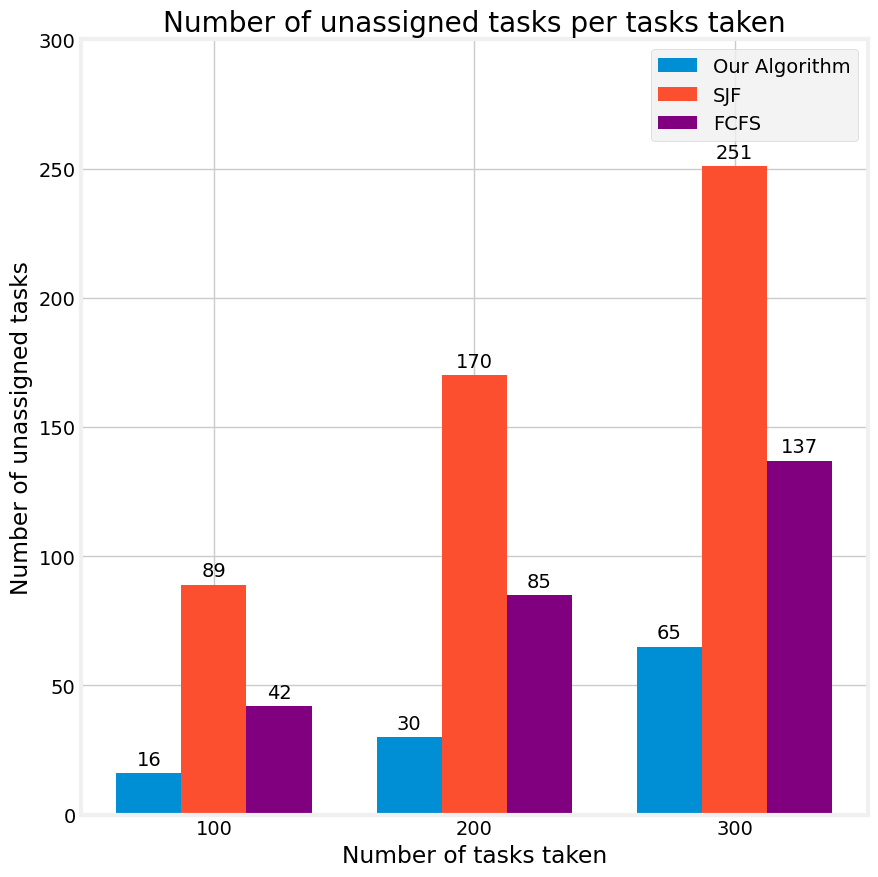

In [ ]:

index = np.arange(len(labels))
bar_width = 0.25


fig, ax = plt.subplots()
fig.set_facecolor("white")
ax.set_facecolor("white")
our_algo = ax.bar(index, unassigned, bar_width, label="Our Algorithm")

sjf = ax.bar(index+ bar_width, sjf_unassigned, bar_width, label="SJF")

fcfs = ax.bar(index+ 2*bar_width, fcfs_unassigned, bar_width, label="FCFS", color='purple')

ax.set_xlabel('Number of tasks taken')
ax.set_ylabel('Number of unassigned tasks')
ax.set_title('Number of unassigned tasks per tasks taken')

ax.set_xticks(index + bar_width)
ax.set_xticklabels(labels)
ax.legend()

for p in our_algo:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

for p in sjf:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

for p in fcfs:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.ylim(0, 300)

plt.show()

In [ ]:
a = np.array([156.19637530578578, 160.56561147850962, 156.43220000918475, 163.10769981595885, 147.63476955400046, 156.66552333199596, 160.10951403165146])
print(np.average(a))

157.2445276467267
